# K-Means Clustering for stock picking

#### by Leticia Albuquerque and Gustavo Soares

## Introduction

In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) but more importantly you will learn how to use Bloomberg's [BQuant](https://www.bloomberg.com/professional/bquantdemo/) platform to run Python inside a Bloomberg terminal and Bloomberg Query Language to retrieve data from the Bloomberg server. You will also learn how to use K-means clustering to select stocks to go long or short based on some of their fundamental characteristics.

#### BQuant and Bloomberg Query Language
Bloomberg is developing a new function in the Terminal, called BQuant, BQNT, under the Bloomberg Anywhere license. Basically, if you type BQNT<GO> on a Bloomberg Terminal, provided you have the license, a JupyterLab type of environment will pop up allowing you to run Jupyter notebooks inside a Bloomberg Terminal. One of the reason that this is such a great idea is that now we can use Jupyter notebook with Bloomberg data pulled into the notebook using a data retrieval interface called Bloomberg Query Language, or BQL.
    
BQL works a lot like SQL. You submit a query request to Bloomberg’s server and get the data directly from server, which also enables basic calculations so as to further reduce the size of data being pulled out. Also, BQNT comes with pre-installed bqplot and some wrappers of libraries like ipwidgets, which makes visualization easy and interactive.
    
## BQL
    
This notebook assumes you are running it inside BQuant and shows how to use the K-means algorithm to form groups os stocks based on certain characteristics of the companies.
    
Let's get started by importing some things we are going to need, including BQL.       

In [2]:
import bql
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
bq = bql.Service() # note that you need to instantiate bql Service like this before using it

Let's see a simple case of how BQL works. Let's try to get the price-to-book ratio for Bank of America (BAC) for the year prior to the end of the current (today's) reporting period:

In [3]:
date = datetime.date.today() # This is getting todays date in datetime
security = 'BAC US Equity'   # This is the security 
period_type = 'a'            # This is for anual reporting period. You can use Q for quarterly.
fill = 'prev'                # This is for taking the prior reporting period

value = bq.data.px_to_book_ratio(fpt=period_type,dates=date,fill=fill)
request = bql.Request(security, {"Price-to-book ratio" : value})
response = bq.execute(request)
response_df = bql.combined_df(response) # Convert the response to a DataFrame and
response_df

,AS_OF_DATE,REVISION_DATE,PERIOD_END_DATE,Price-to-book ratio
ID,,,,
BAC US Equity,2020-01-16,2020-01-15,2019-12-31,1.269005


You may remember from your Python lectures how to use **kwargs parameters to write functions that take dictionaries as argments where the dictionary contains the values for each keyword argument. Just to refresh your memory look at this example:

In [4]:
pararm_dict = dict({'a' : 2, 'b' : 0.5, 'c' : 5})
def f_second_degree_poli(x, **kargs):
    return kargs['a']*x**2 + kargs['b']*x + kargs['c']
f_second_degree_poli(2, **pararm_dict)

14.0

So, using the same logic as above, let's set up parameter dictionaries to use in different data requests below:

In [5]:
params_act = {'fpt': 'a',
             'dates': date,
              'fill': 'prev'
             }

params_est = {'fpt': 'ltm',
             'dates': date,
             'fpo': '1',
              'fill':'prev'
             }
params_func = {'fpt': 'a',
              'dates': bq.func.range(start=date - datetime.timedelta(days=365), end = date),
              'fill': 'prev'}

Now, remember how we used the line

<div>
value = bq.data.px_to_book_ratio(fpt=period_type,dates=date,fill=fill)
<div>

to define the data item, px_to_book_ratio, we wanted. We can now use the parameter dictionaries to do that:

In [6]:
value = bq.data.px_to_book_ratio(**params_act)
request = bql.Request(security, {"Price-to-book ratio" : value})
response = bq.execute(request)
response_df = bql.combined_df(response)  # Convert the response to a DataFrame
response_df

,AS_OF_DATE,REVISION_DATE,PERIOD_END_DATE,Price-to-book ratio
ID,,,,
BAC US Equity,2020-01-16,2020-01-15,2019-12-31,1.269005


Note that once I define the data item, value, I request from the BQL server the data using a the variable, security and a dictionary {"Price-to-book ratio" : value} which assigns a name to that data item. Let's do that now in two steps, (i) creating two data items, price-to-book as well as free-cash-flow-yield and then (ii) creating a fields dictionary to be used in the request:

In [7]:
value1 = bq.data.px_to_book_ratio(**params_act)
value2 = bq.data.earn_yld(**params_act)
fields = {"Price-to-book ratio" : value, 'Free-cash-flow yield' : value2}
request = bql.Request(security, items= fields)
response = bq.execute(request)
response_df = bql.combined_df(response) # Convert the response to a DataFrame
response_df

,AS_OF_DATE,REVISION_DATE,PERIOD_END_DATE,Price-to-book ratio,Free-cash-flow yield
ID,,,,,
BAC US Equity,2020-01-16,2020-01-15,2019-12-31,1.269005,7.9855


Now that we get the idea of how to use **kwargs parameters, let's define a dictionary of fields so we can pull data for many characteristics of the security. Here, we download characteristics normally used to construct portfolios based on factors such as value, size, momentum, low_vol, and quality:

In [8]:
fields = {
        # SECTOR
       'sector': bq.data.gics_sector_name()["value"],
    
        #  VALUE FIELDS
         'book_to_price': bq.data.px_to_book_ratio(**params_act)["value"],
         'earnings_yield': bq.data.earn_yld(**params_act)["value"],
         'free_cash_flow_yield': bq.data.free_cash_flow_yield(**params_act)["value"],
         'eqy_dvd_yld': (bq.data.is_div_per_shr(**params_est)["value"]/bq.data.px_last(dates=date))["value"],
         'stock_buyback': bq.data.cf_decr_cap_stock(**params_act)["value"],
    
        #  SIZE FIELDS
        'market_cap': bq.data.cur_mkt_cap(dates=date)["value"],
    
        # MOMENTUM
        '12m_1w_px_momentum': (bq.func.pct_chg(bq.data.px_last(start= date- datetime.timedelta(days=365), end=date-datetime.timedelta(days=7),fill='prev')))["value"],
        'tot_return_1y': bq.data.total_return(calc_interval='1y')['value'],
    
        # LOW VOLATILITY
        'volatility_1y': (bq.data.volatility(calc_interval=bq.func.range(start= date- datetime.timedelta(days=365),end=date)))["value"],
        
        #  QUALITY   
        # Profitability
        'roe': bq.data.return_com_eqy(**params_act)["value"],
        'oper_csh_flow_to_assets': bq.data.CF_CASH_FROM_OPER(**params_act)["value"]/bq.data.net_assets(**params_act)["value"],
        'gross_profit_to_assets': bq.data.gross_profit(**params_act)["value"]/bq.data.net_assets(**params_act)["value"],
        # Leverage
        'net_debt_to_assets': (bq.data.net_debt(**params_act)/bq.data.net_assets(**params_act))["value"],
        'net_debt_to_ebitda': (bq.data.net_debt(**params_act)/bq.data.ebitda(**params_act))["value"],
        'delta_return_assets': (bq.data.return_on_asset(**params_act)-bq.data.return_on_asset(**params_act,fa_period_offset='-1'))["value"],
        'delta_leverage': (bq.data.bs_tot_asset(**params_act)/bq.data.tot_common_eqy(**params_act))["value"],
        'delta_cur_ratio': bq.data.cur_ratio(**params_act)["value"],
        'eqy_issuance': (bq.data.BS_SH_OUT(**params_act)- bq.data.bs_sh_out(**params_act,fa_period_offset='-1'))["value"],
        'delta_gross_margin': bq.data.gross_margin(**params_act)-bq.data.gross_margin(**params_act, fa_period_offset='-1')["value"],
        'delta_asset_turnover': bq.data.asset_turnover(**params_act)-bq.data.asset_turnover(**params_act, fa_period_offset='-1')["value"],
        'roa_variability': bq.func.std(bq.data.return_on_asset(**params_func))["value"],
        'revenue_growth_variability': bq.func.std(bq.data.sales_rev_turn(**params_func))["value"],
        'rd_assets': (bq.data.IS_RD_EXPEND(**params_act)/bq.data.net_assets(**params_act))["value"],
        'adv_exp_assets': (bq.data.is_advertising_expenses(**params_act)/bq.data.net_assets(**params_act))["value"],
}

Let's pull all the data for BAC now:

In [9]:
req = bql.Request(security, items = fields)
resp = bq.execute(req)
df = bql.combined_df(resp)
df.dropna(axis=1)

,earnings_yield,roa_variability,delta_leverage,delta_asset_turnover,delta_return_assets,sector,volatility_1y,revenue_growth_variability,eqy_dvd_yld,roe,tot_return_1y,book_to_price,12m_1w_px_momentum,eqy_issuance,market_cap,net_debt_to_assets
ID,,,,,,,,,,,,,,,,
BAC US Equity,7.9855,0.005072,10.082801,-0.000268,-0.068706,Financials,0.218552,2.218315e+08,0.022714,10.733927,0.24613,1.269005,23.128295,-833137416.0,3.063493e+11,0.265001


Suppose now, we wanted to do this for all stocks in the S&P 500 index. We can use BQL univ.members methods do do that:

In [10]:
univ = bq.univ.members('SPX Index') #defining the universe
req = bql.Request(universe = univ, items = fields)
resp = bq.execute(req)
df = bql.combined_df(resp)
df = df.dropna()
df.head()

,earnings_yield,roa_variability,delta_leverage,free_cash_flow_yield,delta_asset_turnover,delta_return_assets,sector,net_debt_to_ebitda,volatility_1y,revenue_growth_variability,...,book_to_price,12m_1w_px_momentum,rd_assets,oper_csh_flow_to_assets,gross_profit_to_assets,eqy_issuance,delta_cur_ratio,market_cap,net_debt_to_assets,stock_buyback
ID,,,,,,,,,,,,,,,,,,,,,
VZ UN Equity,8.574093,1.122960,4.983140,7.233716,-0.001388,-6.058881,Communication Services,2.780121,0.154907,8.950128e+08,...,4.595036,3.100911,0.000000,0.627655,1.377353,52557007.0,0.913156,2.444248e+11,2.016414,0.000000e+00
KO UN Equity,3.749489,1.648622,4.900536,2.585100,-0.012552,6.095287,Consumer Staples,2.744579,0.167611,1.279838e+09,...,14.250963,17.945439,0.000000,0.400199,1.114125,9000000.0,0.866166,2.429307e+11,1.474394,-1.912000e+09
DIS UN Equity,3.480842,2.140411,2.182612,0.665072,-0.135943,-5.405600,Communication Services,2.605334,0.223929,4.013468e+09,...,2.895266,30.583356,0.000000,0.064228,0.267880,283000000.0,0.897355,2.601221e+11,0.405573,0.000000e+00
PSX UN Equity,10.951767,0.164614,2.202653,10.586014,0.366786,0.665164,Energy,1.245372,0.212572,5.385343e+09,...,1.940826,13.582106,0.002026,0.278901,0.432733,-46104425.0,1.478344,4.660867e+10,0.299820,-4.645000e+09
IBM UN Equity,9.906826,0.289848,7.346572,9.795382,-0.011858,2.279454,Information Technology,1.652810,0.200156,5.747491e+07,...,7.260147,12.432166,0.317720,0.900591,2.181689,-29699815.0,1.285636,1.209958e+11,1.627525,-4.614000e+09


In the DataFrame above we have 126 stocks for which we have all the data in the 25 fields we requested.

## Clustering

Clustering refers to algorithms for finding subgroups, or clusters, in a data set. Here, we will use a clustering algorithm to split stocks into different groups according to the characteristics we listed above. Broadly speaking, those characteristics are often used to group stocks by sector, value, size, momentum, volatility and quality.

Here, we are going to use **K-Means clustering**. Let's start with a simple case in which we want to group stocks from the Consumer Discretionary sector according to two characteristics: value (as measured by book-to-price) and momentum. As it is typical in these situations, we will normalize the value and momentum using a within-sector cross-sectional z-score:

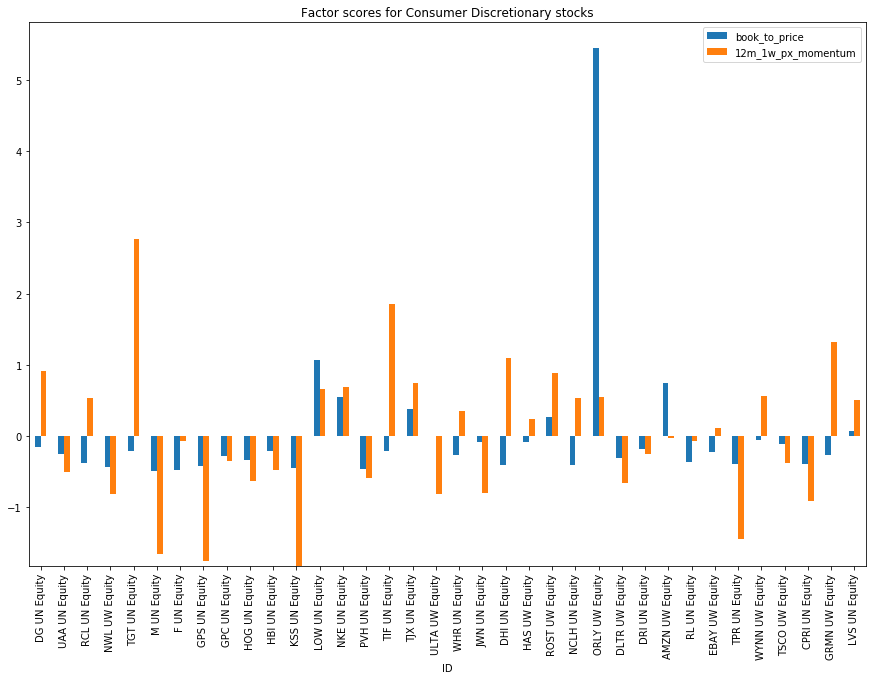

In [35]:
cons_disc_df = df[df['sector']=='Consumer Discretionary']
two_factor_df = cons_disc_df[['book_to_price','12m_1w_px_momentum']]
two_factor_df = (two_factor_df - two_factor_df.mean())/two_factor_df.std()
two_factor_df.plot(kind='bar',figsize=(15,10),
                   title='Factor scores for Consumer Discretionary stocks')
two_factor_df = two_factor_df.rank()

The K-means clustering partitions the observations into K clusters such that the total *within-cluster variation*, summed over all K clusters, is as small as possible. There are many possible ways to define within-cluster variation, but by far the most common choice involves squared Euclidean distance. So, the within-cluster variation for the kth cluster is the sum of all of the pairwise squared Euclidean distances between the observations in the kth cluster, divided by the total number of observations in the kth cluster.

The K-Means Clustering Algorithm solves this problem like this:

1. Randomly assign a number, from 1 to K, to each of the observations. These serve as initial cluster assignments for the observations.
2. Iterate until the cluster assignments stop changing:

    (a) For each of the K clusters, compute the cluster centroid. The kth cluster centroid is the vector of the p feature means for the observations in the kth cluster.
    
    (b) Assign each observation to the cluster whose centroid is closest (where closest is defined using Euclidean distance).

Let's see how that works in our example. Remember, to perform K-means clustering, we must first specify the desired number of clusters K; then the K-means algorithm will assign each observation to exactly one of the K clusters. Let's start with the case we set K = 4 clusters:

In [36]:
# creating kmeans object
kmeans = KMeans(n_clusters=4, init = 'k-means++',random_state=0)
# fit kmeans object to data
kmeans.fit(two_factor_df.values)
# print location of clusters learned by kmeans object
centroids = kmeans.cluster_centers_
# save new clusters for chart
labels  = kmeans.fit_predict(two_factor_df.values)
two_factor_df['clusters'] = labels + 1 
two_factor_df

,book_to_price,12m_1w_px_momentum,clusters
ID,,,
DG UN Equity,24.0,32.0,3
UAA UN Equity,18.0,12.0,2
RCL UN Equity,11.0,25.0,3
NWL UW Equity,5.0,6.0,4
TGT UN Equity,22.0,36.0,3
M UN Equity,1.0,3.0,4
F UN Equity,2.0,18.0,4
GPS UN Equity,6.0,2.0,4
GPC UN Equity,15.0,15.0,2


Let's visualize this:

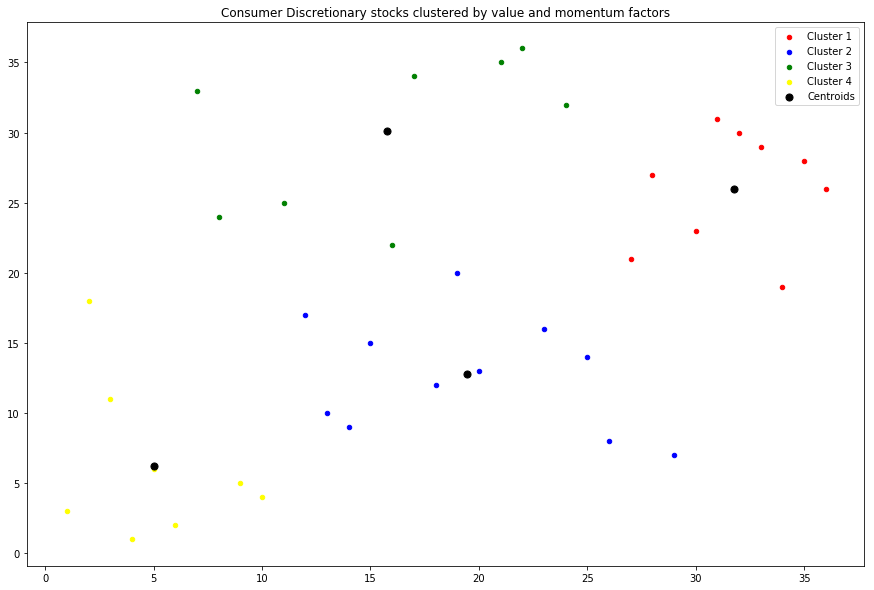

In [41]:
# Visualising the clusters
plt.figure(figsize=(15,10))
#Scatter plotting  (x,y) with label 1 as Cluster 1 in color c = red
c = 1
plot_df = two_factor_df[two_factor_df['clusters'] == c]
plt.scatter(plot_df.iloc[:,0], plot_df.iloc[:,1], s = 20, c = 'red', label = 'Cluster 1')
# #Scatter plotting (x,y) with label 2 as Cluster 2 in color c = blue 
c = 2
plot_df = two_factor_df[two_factor_df['clusters'] == c]
plt.scatter(plot_df.iloc[:,0], plot_df.iloc[:,1], s = 20, c = 'blue', label = 'Cluster 2')
# #Scatter plotting (x,y) with label 3 as Cluster 3 in color c = green
c = 3
plot_df = two_factor_df[two_factor_df['clusters'] == c]
plt.scatter(plot_df.iloc[:,0], plot_df.iloc[:,1], s = 20, c = 'green', label = 'Cluster 3')
# #Scatter plotting (x,y) with label 4 as Cluster 4 in color c = yellow
c = 4
plot_df = two_factor_df[two_factor_df['clusters'] == c]
plt.scatter(plot_df.iloc[:,0], plot_df.iloc[:,1], s = 20, c = 'yellow', label = 'Cluster 4')


plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 50, c = 'k', label = 'Centroids')
plt.legend()
plt.title('Consumer Discretionary stocks clustered by value and momentum factors')
plt.show()

## Stock picking by clustering

Cluster 1 seems to be the stocks that have high book-to-price (so they are cheap) and high momentum. Cluster 1 seems like a good set of Consumer Discretionary stocks to be long! Cluster 4, on the other hand, it's the oppposite. Cluster 4 seems to gather the Consumer Discretionary stocks that are expensive and have low momentum. So, perhaps, a good group to short! The other two groups do not seem to be good stocks in one metric but not in the other.

## The elbow method
It is common in practice for us not to know exactly with how many clusters to start. The elbow method is a common method to solve that problem. It looks at the percentage of variance explained as a function of the number of clusters. So, we can add clusters until the marginal benefit of adding an extra one is not very large. We plot the percentage of variance explained by the clusters against the number of clusters, the first clusters will add a lot of information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified but it is a good visual tool.

Let's use the elbow method to see if 4 clusters was really a good choice in our case:

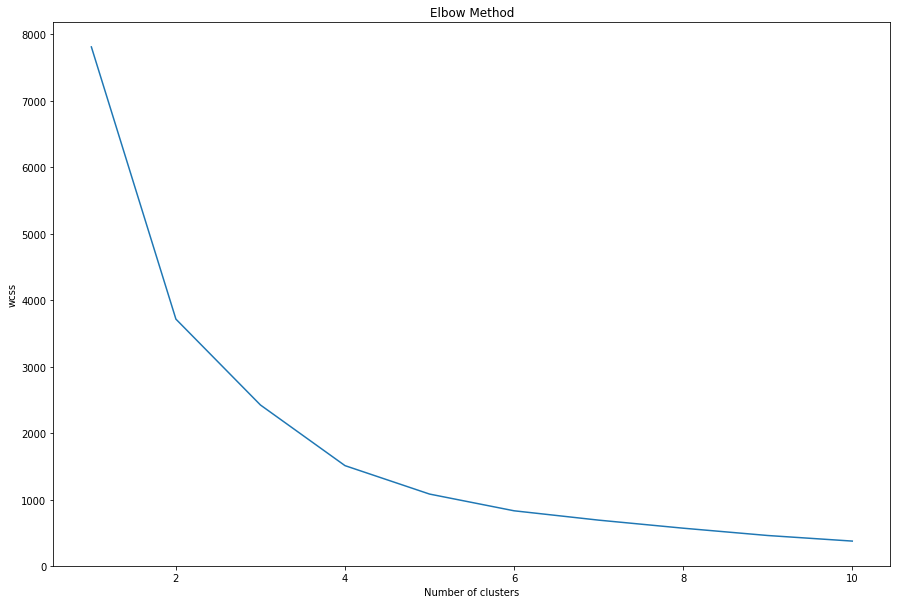

In [46]:
#Using the elbow method to find the # of clusters
plt.figure(figsize=(15,10))
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(two_factor_df.values)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

Here, it seems 4 clusters is a good number of cluster but someone perhaps may say that 6 would be better. So, there is some discretion on that choice. In our application, where we used the clustering algorithm to find out what stocks to go long and what to go short, perhaps the number of clusters is less important than the number of stocks that end up in each cluster.

Because the K-means algorithm finds a local rather than a global optimum, the results obtained will depend on the initial (random) cluster assignment of each observation as well as the initial number of clusters.

## Exercises

#### Beginners

Using the method we discussed here and using metrics from the factors low_vol and quality, see if you can use clustering to pick which stocks you would like to go long and short based on these two metrics. Run this exercise on a sector by sector basis (or perhaps combining similar sectors into one) to create a long and short portfolio that is diversified across different sectors.

#### Intermediate

Using the method we discussed here and using all metrics from the factors low_vol and quality, see if you can use clustering to pick which stocks you would like to go long and short based on these two metrics. You will need to think about how to combine the metrics in each factor to have a single final metric representing that factor. Run this exercise on a sector by sector basis (or perhaps combining similar sectors into one) to create a long and short portfolio that is diversified across different sectors.

#### Intermediate

Using the method we discussed here and using one metric for each of the factors value, momentum, size, low_vol and quality, see if you can use clustering to pick which stocks you would like to go long and short based on these two metrics. You will not be able to "plot" the clusters anymore because now you are dealing with 5 different factors. Run this exercise on a sector by sector basis (or perhaps combining similar sectors into one) to create a long and short portfolio that is diversified across different sectors.

#### Advanced

Using the method we discussed here and using using all metrics for each of the factors value, momentum, size, low_vol and quality, see if you can use clustering to pick which stocks you would like to go long and short based on these five factors.  You will need to think about how to combine the metrics in each factor to have a single final metric representing that factor. Also, you will not be able to "plot" the clusters anymore because now you are dealing with 5 different factors. Run this exercise on a sector by sector basis (or perhaps combining similar sectors into one) to create a long and short portfolio that is diversified across different sectors.

In [47]:
import os
os.getcwd()

'C:\\Users\\gsoares\\AppData\\Local\\bipy\\18430058\\projects\\5b1269044d154b02b7f5887e6f9fadb2'